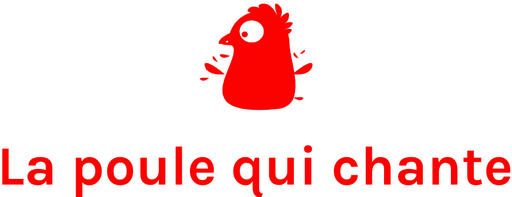

# <span style="color:purple">Produisez une étude de marché (ACP, clustering)
<span style="color:purple">============================================================================

<span style="font-size:1.1em">J'importe les librairies nécessaires.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import sklearn
from sklearn import preprocessing, decomposition, cluster, metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

<span style="font-size:1.1em">I use the data preparation and cleaning notebook to be able to use the final dataframe.

In [2]:
%run Propjet_FAO_preparation_nettoyage_analyse_exploratoire_042023.ipynb

Exception: File `'Propjet_FAO_preparation_nettoyage_analyse_exploratoire_042023.ipynb.py'` not found.

In [ ]:
# dataframe final du notebook de préparation et nettoyage
df_analyse

<span style="font-size:1.1em">Je peux donc commencer les différentes analyses demandées.

## <span style="color:blue">I. Analyse de la liste complète des pays
### <span style="color:orange">1. Analyse en composantes principales : ACP

<span style="font-size:1.1em">L'ACP permet d'étudier la variabilité entre les individus, c'est-à-dire les différences et les ressemblances, et d'étudier les liaisons entre les variables, c'est-à-dire les corrélations entre elles.

<span style="font-size:1.1em">J'utilise les noms de pays comme index, que je vais enregistrer dans une variable 'pays'.

In [ ]:
df_analyse_ = df_analyse
df_analyse_.index = df_analyse['Pays']
pays = df_analyse_.index
pays

<span style="font-size:1.1em">Puis, je sélectionne les colonnes que je vais utiliser dans les analyses, et je les enregistre dans une variable 'features'.

In [ ]:
df_analyse_ = df_analyse[['Population','Disponibilité alimentaire (Kcal/personne/jour)',
       'Disponibilité alimentaire en quantité (kg/personne/an)',
       'Disponibilité de matière grasse en quantité (g/personne/jour)',
       'Disponibilité de protéines en quantité (g/personne/jour)',
       'Disponibilité_intérieure', 'Exportations', 'Importations',
       'Nourriture', 'Production','PIB_habitant annuel en USD','Indice de stabilité politique']]

In [ ]:
features = df_analyse_.columns
features

<span style="font-size:1.1em">Afin de remédier au problème de concordance des unités, je normalise les données en procédant au centrage et à la réduction, c'est-à-dire soustraction de la moyenne puis division par l'écart-type.

In [ ]:
# centrage et réduction
X = df_analyse_.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# moyenne = 0 et écart-type = 1 
idx = ['mean', 'std']
pd.DataFrame(X_scaled).describe().round(2).loc[idx,:]

<span style="font-size:1.1em">Je choisis d'étudier toutes les composantes.

In [ ]:
n_components = 12
pca = PCA(n_components=n_components)
pca.fit(X_scaled)

<span style="font-size:1.1em">Je calcule la proportion de variance captée pour chacune des composantes, que j'enregistre dans une variable 'scree' (éboulis).

In [ ]:
pca.explained_variance_ratio_
scree = (pca.explained_variance_ratio_*100).round(2)
scree

<span style="font-size:1.1em">Je calcule la somme cumulée des proportions des différentes composantes.
    
<span style="font-size:1.1em">On peut voir, par exemple, que les **2 premières composantes** captent **72 % de la variance**.

In [ ]:
scree_cum = scree.cumsum().round()
scree_cum

<span style="font-size:1.1em">Je crée l'éboulis des valeurs propres, avec la variance pour chaque composante en bleu et la courbe de la variance cumulée en rouge.

In [ ]:
x_list = range(1, n_components+1)
list(x_list)
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c='red',marker='o')
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")
plt.title('Eboulis des valeurs propres', size='14', color='red')
plt.show(block=False)

<span style="font-size:1.1em">Le tableau suivant, obtenu avec l'attribut 'components_', permet d'effectuer le calcul afin d'obtenir les différentes composantes.

In [ ]:
pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs.columns = features
pcs.index = [f'F{i}' for i in x_list]
pcs.round(2)
round(pcs.T,2)

<span style="font-size:1.1em">Je peux donc réaliser le cercle des corrélations des 2 premières composantes.

In [ ]:
# cercle des corrélations
x, y = 0,1
fig, ax = plt.subplots(figsize=(10, 8))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0, 0, pca.components_[0, i], pca.components_[1, i], head_width=0.07, head_length=0.07, width=0.02,)

    plt.text(pca.components_[0, i] + 0.05,pca.components_[1, i] + 0.05,features[i])
    
# lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='red', ls='--')
plt.plot([0, 0], [-1, 1], color='red', ls='--')

# nom des axes avec le pourcentage d'inertie
plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title('Cercle des corrélations (F{} et F{})'.format(x+1, y+1), size='14', color='red')

an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an)) 
plt.axis('equal')
plt.show(block=False)

In [ ]:
plt.figure(figsize=(8, 4))
mask = np.triu(np.ones_like(df_analyse.corr()))
sns.heatmap(df_analyse.corr(), mask=mask, cmap='plasma')
plt.title('Corrélation des différentes variables entre elles', size='14', color='red')
plt.show()

<span style="font-size:1.1em">Il y a des variables qui sont fortement corrélées : Production, Nourriture et Disponibilié intérieure sont fortement corrélées, et Disponibilité alimentaire (Kcal/personne/jour), Disponibilité alimentaire en quantité (kg/personne/an), Disponibilité de matière grasse en quantité (g/personne/jour), Disponibilité de protéines en quantité (g/personne/jour) sont fortement corrélées aussi. Pour une meilleure analyse, il faut donc réduire le nombre de variables étudiées.
    
<span style="font-size:1.1em">Je refais la même démarche avec moins de variables.

In [ ]:
df_analyse_ = df_analyse[['Population','Disponibilité alimentaire en quantité (kg/personne/an)',
                             'Exportations', 'Importations', 'Production','PIB_habitant annuel en USD',
                             'Indice de stabilité politique']]

In [ ]:
features = df_analyse_.columns
features

In [ ]:
# centrage et réduction
X = df_analyse_.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# moyenne = 0 et écart-type = 1 
idx = ['mean', 'std']
pd.DataFrame(X_scaled).describe().round(2).loc[idx,:]

In [ ]:
# nombre de composantes
n_components = 7
pca = PCA(n_components=n_components)
pca.fit(X_scaled)

In [ ]:
# proportion de variance captée pour chaque composante
pca.explained_variance_ratio_
scree = (pca.explained_variance_ratio_*100).round(2)
scree

In [ ]:
# somme cumulée des proportions
scree_cum = scree.cumsum().round()
scree_cum

In [ ]:
# éboulis des valeurs propres
x_list = range(1, n_components+1)
list(x_list)
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c='red',marker='o')
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")
plt.title('Eboulis des valeurs propres', size='14', color='red')
plt.show(block=False)

In [ ]:
pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs.columns = features
pcs.index = [f'F{i}' for i in x_list]
pcs.round(2)
round(pcs.T,2)

<span style="font-size:1.1em">Je crée une fonction qui me permet d'afficher le cercle des corrélations des différentes composantes.

In [ ]:
def cercle_correlations(pca, x_y, features) : 
    x,y=x_y
    fig, ax = plt.subplots(figsize=(8, 8))

    for i in range(0, pca.components_.shape[1]):
        # flèches
        ax.arrow(0,0, pca.components_[x, i], pca.components_[y, i], head_width=0.07, head_length=0.07, width=0.02, )
        # labels
        plt.text(pca.components_[x, i] + 0.05, pca.components_[y, i] + 0.05, features[i])
        
    # lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='red', ls='--')
    plt.plot([0, 0], [-1, 1], color='red', ls='--')

    # axes et pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    plt.title('Cercle des corrélations (F{} et F{})'.format(x+1, y+1), size='14', color='red')

    # cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))
    
    plt.axis('equal')
    plt.show(block=False)

<span style="font-size:1.1em">Tout d'abord, je l'affiche pour les **2 premières composantes**, qui représentent **61 % de la variance**.

In [ ]:
x_y = (0,1)
cercle_correlations(pca, x_y, features)

<span style="font-size:1.1em">Le cercle montre une corrélation entre la production et les exportations, et une corrélation entre la disponibilité alimentaire et le PIB/hab. F1 correspond aux ressources du pays. En effet, à droite sur le cercle, ce sont les pays riches, réalisant du commerce, et à gauche, les pays pauvres ne réalisant pas de commerce. En haut, il y a les pays peuplés instables politiquement, et en bas, les pays faiblement peuplés mais stables politiquement. 
    
<span style="font-size:1.1em">Ensuite, je l'affiche pour les **troisième et quatrième composantes**, qui représentent **85 %** de la variance.

In [ ]:
cercle_correlations(pca, (2,3), features)

<span style="font-size:1.1em">**F3** est liée **mouvements du stock** (importations et exportations), pour les pays, à gauche ceux qui importent le plus. 

<span style="font-size:1.1em">Je crée, ensuite, une fonction pour représenter les individus sur un plan factoriel.

In [ ]:
X_proj = pca.transform(X_scaled)

In [ ]:
def plan_factoriel(X_projected, x_y,pca=None, labels = None, clusters=None, alpha=1, figsize=[14,8], marker='o' ):
   
    X_ = np.array(X_projected)

    x, y = x_y
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # clusters
    c = None if clusters is None else clusters
 
    # points    
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    # % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # axes et pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} ({v1})')
    ax.set_ylabel(f'F{y+1} ({v2})')

    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='blue', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='blue', alpha=0.8)

    # labels
    if len(labels) : 
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='10', ha='center',va='center') 

    plt.title(f'Projection des individus (sur F{x+1} et F{y+1})', size='14', color='red')
    plt.show()

<span style="font-size:1.1em">J'affiche la représentation des individus étudiés sur le premier plan factoriel.

In [ ]:
x_y = 0,1
plan_factoriel(X_proj, x_y, pca, labels=pays,
                         clusters=df_analyse_['Disponibilité alimentaire en quantité (kg/personne/an)'], marker="o")

<span style="font-size:1.1em">**4 pays outliers** se distinguent : l'Inde, la Chine continentale, le Brésil et les Etats-Unis d'Amérique, qui se démarquaient déjà dans l'analyse exploratoire, pour les premiers sur la variable population et, pour les 2 autres, les variables production et exportations.
    
<span style="font-size:1.1em">Pour une meilleure visibilité, je représente donc les individus sans les noms de pays, en faisant la même fonction mais sans les labels.

In [ ]:
def plan_factoriel_(X_projected, x_y,pca=None, labels = None, clusters=None, alpha=1, figsize=[14,8], marker='o' ):
   
    X_ = np.array(X_projected)

    x, y = x_y
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # clusters
    c = None if clusters is None else clusters
 
    # points    
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    # % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # axes et pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} ({v1})')
    ax.set_ylabel(f'F{y+1} ({v2})')

    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='blue', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='blue', alpha=0.8)

    plt.title(f'Projection des individus (sur F{x+1} et F{y+1})', size='14', color='red')
    plt.show()

<span style="font-size:1.1em">Pour le premier plan factoriel, j'utilise la variable 'Disponibilité alimentaire en quantité'.

In [ ]:
x_y = 0,1
plan_factoriel_(X_proj, x_y, pca, labels=pays,
                         clusters=df_analyse_['Disponibilité alimentaire en quantité (kg/personne/an)'], marker="o")

<span style="font-size:1.1em">La projection confirme bien le cercle des corrélations, en haut à gauche, les pays ayant le moins de disponibilités et donc le plus de besoins.

<span style="font-size:1.1em">Pour le second plan factoriel, j'utilise la variable 'Importations' afin d'illustrer l'analyse du cercle de corrélations, car elle y est bien représentée.

In [ ]:
x_y = 2,3
plan_factoriel_(X_proj, x_y, pca, labels=pays,
                         clusters=df_analyse_['Importations'], marker="o")

<span style="font-size:1.1em">Sur cette projection, les pays qui importent le plus sont bien à gauche en confirmant le cercle des corrélations.
    
<span style="font-size:1.1em">Ensuite, je fais le clustering.

### <span style="color:orange">2. Classification hiérarchique : Dendrogramme
    
<span style="font-size:1.1em">Je calcule les distances des différents individus avec la méthode de Ward.

In [ ]:
# calcul des distances avec la méthode de Ward
Z = linkage(X_scaled, method='ward')

<span style="font-size:1.1em">Puis, j'affiche le dendrogramme correspondant.

In [ ]:
# dendrogramme
fig, ax = plt.subplots(1, 1, figsize=(20,40))
_ = dendrogram(Z, ax=ax, labels=pays, orientation = 'left')
plt.title('Dendrogramme', size='14', color='red')
ax.set_xlabel('Distance')
ax.set_ylabel('Pays')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=15)

<span style="font-size:1.1em">Pour avoir une meilleure lisibilité, j'affiche le dendrogramme tronqué en 6 clusters.

In [ ]:
# dendrogramme tronqué
fig, ax = plt.subplots(1, 1, figsize=(15,8))
_ = dendrogram(Z, ax=ax, labels=pays, orientation = 'left', p=6, truncate_mode='lastp')
plt.title('Dendrogramme', size='14', color='red')
ax.set_xlabel('Distance')
ax.set_ylabel('Pays')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=15)

<span style="font-size:1.1em">Les 2 premiers clusters regroupent seulement deux pays chacun, alors que 6 autres regroupent de 10 à 85 pays chacun. 
    
<span style="font-size:1.1em">Ensuite, je crée un dataframe avec les pays et les clusters auxquels ils appartiennent. 
    
<span style="font-size:1.1em">Puis, je fais la jointure avec le fichier d'analyse.

In [ ]:
cluster = fcluster(Z, 6, criterion='maxclust')
df_cluster = pd.DataFrame({'Pays':pays, 'Cluster':cluster})

In [ ]:
# jointure
df_analyse_cluster = pd.merge(df_analyse_, df_cluster, on = 'Pays')
df_analyse_cluster

<span style="font-size:1.1em">Je regarde à quels pays correspondent les 2 premiers clusters.

In [ ]:
# premier cluster
df_analyse_cluster.loc[df_analyse_cluster['Cluster']==1]

In [ ]:
# second cluster
df_analyse_cluster.loc[df_analyse_cluster['Cluster']==2]

<span style="font-size:1.1em">Les 4 pays outliers se distinguent dans le dendrogramme. En effet, ces pays représentent à eux-seuls 2 clusters.
    
<span style="font-size:1.1em">Je regarde, ensuite, le clustering avec la méthode des K-means.

### <span style="color:orange">3. K means
    
<span style="font-size:1.1em">Tout d'abord, je normalise les données et j'affiche la courbe afin de déterminer le nombre k de clusters avec la méthode Elbow, c'est-à-dire la méthode du coude.

In [ ]:
X = preprocessing.scale(df_analyse_)

tab = []
for k in range(2,11):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X)
    tab.append(kmeans.inertia_)
    
plt.plot(range(2,11), tab)
plt.title('Méthode du coude')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.show()

<span style="font-size:1.1em">Au vu de la courbe, je décide de choisir k=6.
    
<span style="font-size:1.1em">Je représente le nuage de points des individus avec les 6 clusters en fonction des 2 premières composantes.

In [ ]:
# nuage de points (individus) en clusters
fig = plt.figure(figsize=(12,6))
kmeans = KMeans(n_clusters = 6)
kmeans.fit(X)
X_trans = pca.transform(X)
plt.scatter(X_trans[:,0], X_trans[:,1],c=kmeans.labels_)
plt.title('Projection des individus en 6 clusters (sur F1 et F2)', size='14', color='red')
plt.show()

<span style="font-size:1.1em">Je fais, comme pour le dendrogramme, je crée le dataframe avec les pays et les clusters auxquels ils appartiennent.
    
<span style="font-size:1.1em">Puis, je fais la jointure avec le fichier d'analyse.

In [ ]:
indexk = np.argsort(kmeans.labels_)
df_clusterk = pd.DataFrame(df_analyse_.index[indexk], kmeans.labels_[indexk]).reset_index()
df_clusterk = df_clusterk.rename(columns={'index':'ClusterK'})

# jointure
df_analyse_clusterk = pd.merge(df_analyse_, df_clusterk, on='Pays')
df_analyse_clusterk

In [ ]:
# nombre de pays par cluster
df_analyse_clusterk['ClusterK'].value_counts()

In [ ]:
# coefficient de silhouette pour le clustering en 6 clusters
metrics.silhouette_score(X_trans, kmeans.labels_)

<span style="font-size:1.1em">Le coefficient de silhouette est compris entre -1 et 1, sachant que 1 est un clustering parfait. Ici, le coefficient est égal à 0,36.

### <span style="color:orange">4. Comparaison clusterings

<span style="font-size:1.1em">Il faut donc ensuite **comparer les résultats des 2 clusterings**, voir la correspondance entre eux.
    
<span style="font-size:1.1em">Puis, je regarde les caractéristiques des différents groupes.

In [ ]:
df_comparaison = pd.merge(df_analyse_cluster, df_clusterk, on = 'Pays')
df_comparaison

In [ ]:
# pour faciliter la comparaison des clusters du dendrogramme et du K-means
df_comparaison['Cluster'] = df_comparaison['Cluster']-1

<span style="font-size:1.1em">Tout d'abord, je regarde la correspondance des pays des différents clusters, les pays qui sont identiques ou non dans les clusters.

In [ ]:
cluster0 = df_comparaison.loc[df_comparaison['Cluster']==0]
cluster0

<span style="font-size:1.1em">Le premier cluster (**Groupe 0**) correspond à 2 pays outliers : le Brésil et les États-Unis d'Amérique, ce sont des gros producteurs et exportateurs. 

In [ ]:
cluster1 = df_comparaison.loc[df_comparaison['Cluster']==1]
cluster1

<span style="font-size:1.1em">Le second cluster (**Groupe 1**) correspond aux 2 autres outliers : la Chine,continentale et l'Inde, qui se regroupent principalement par une population très élevée.
    
<span style="font-size:1.1em">Pour les **2 premiers groupes**, il y a une correspondance des pays des 2 clusterings, de **100 %** pour les pays outliers. 

In [ ]:
cluster2 = df_comparaison.loc[df_comparaison['Cluster']==2]
cluster2.head(60)

In [ ]:
cluster2.tail(25)

In [ ]:
cluster2['ClusterK'].value_counts()

<span style="font-size:1.1em">Pour ce troisième cluster (**Groupe 2**), la correspondance entre les 2 est **supérieure à 95 %**.

In [ ]:
# pays avec cluster différent
cluster2.loc[cluster2['ClusterK']==5]

In [ ]:
# pays avec cluster différent
cluster2.loc[cluster2['ClusterK']==3]

<span style="font-size:1.1em">Ce troisième groupe correspond à des pays qui connaissent ou ont connu les catastrophes, les conflits, la guerre, qui sont politiquement instables, exemples de ce groupe : l'Afghanistan, Haïti, le Liban, le Pérou, la Serbie, l'Ukraine, le Vietnam ou la Zambie.
    
<span style="font-size:1.1em">Dans ce groupe, la méthode **K-means** classe seulement **2 pays** différemment : la **Fédération de Russie** dans le **clusterK 5** avec, par exemple, l'Argentine, le Gabon, Israël, la Nouvelle-Calédonie, et la **Pologne** dans le **clusterK 3** avec, par exemple, le Canada, la Norvège, la Suède, la Suisse.

In [ ]:
cluster3 = df_comparaison.loc[df_comparaison['Cluster']==3]
cluster3

<span style="font-size:1.1em">Pour ce **groupe 3**, la correspondance est de **90 %**. En effet, seule la **Belgique** est classée différemment, dans le clusterK 3, avec la méthode K-means, comme pour la Pologne précédemment.
    
<span style="font-size:1.1em">Ce groupe correspond aux pays qui ont de fortes importations. En effet, la Belgique est légèrement plus faible que les autres avec seulement 338 milliers de tonnes.

In [ ]:
cluster4 = df_comparaison.loc[df_comparaison['Cluster']==4]
cluster4

In [ ]:
cluster4['ClusterK'].value_counts()

<span style="font-size:1.1em">Le groupe 4 a une correspondance **supérieure à 75 %**.
    
<span style="font-size:1.1em">Les pays de ce groupe ont un PIB/hab annuel élevé. La méthode K-means classe l'**Australie**, les **Bahamas**, le**Koweit** dans le clusterK 5, et les **Émirats arabes unis** dans le clusterK 2 avec l'Allemagne, la France, les Pays-Bas.

In [ ]:
cluster5 = df_comparaison.loc[df_comparaison['Cluster']==5]
cluster5.head()

In [ ]:
cluster5['ClusterK'].value_counts()

<span style="font-size:1.1em">Pour ce dernier **groupe 5**, la correspondance n'est que **seulement de 50 %**.

In [ ]:
# pays identiques aux 2 méthodes
cluster5.loc[cluster5['ClusterK']==5]

In [ ]:
# pays avec cluster différent
cluster5.loc[cluster5['ClusterK']==0]

In [ ]:
# pays avec cluster différent
cluster5.loc[cluster5['ClusterK']==3]

<span style="font-size:1.1em">Ce groupe a une disponibilité alimentaire relativement correcte et une stabilité politique. 
    
<span style="font-size:1.1em">La méthode K-means classe différemment la moitié des pays de ce groupe dans les clusters 0 et 3, certains pays avec une disponibilité alimentaire plus faible : par exemple, le Botswana, la Grèce, la Mongolie, la Namibie dans le clusterK 0 et, la Bulgarie, Chypre, l'Espagne, l'Estonie dans le clusterK 3. 
    
<span style="font-size:1.1em">Pour une meilleure visualisation des graphiques utilisés pour la comparaison, je crée une colonne supplémentaire pour que les numéros de clusters des 2 méthodes soient identiques.

In [ ]:
df_comparaison.loc[df_comparaison['ClusterK']==1, 'ClusterKM']=0

In [ ]:
df_comparaison.loc[df_comparaison['ClusterK']==4, 'ClusterKM']=1

In [ ]:
df_comparaison.loc[df_comparaison['ClusterK']==0, 'ClusterKM']=2

In [ ]:
df_comparaison.loc[df_comparaison['ClusterK']==2, 'ClusterKM']=3

In [ ]:
df_comparaison.loc[df_comparaison['ClusterK']==3, 'ClusterKM']=4

In [ ]:
df_comparaison.loc[df_comparaison['ClusterK']==5, 'ClusterKM']=5

<span style="font-size:1.1em">Je regarde ensuite les caractéristiques des différents groupes.

In [ ]:
means = pd.DataFrame(df_comparaison.groupby('Cluster').mean())
means = means[['Population', 'Disponibilité alimentaire en quantité (kg/personne/an)', 'Exportations', 
                        'Importations', 'Production', 'PIB_habitant annuel en USD', 'Indice de stabilité politique']]
X = means.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

meansK = pd.DataFrame(df_comparaison.groupby('ClusterKM').mean())
meansK = meansK[['Population', 'Disponibilité alimentaire en quantité (kg/personne/an)', 'Exportations', 'Importations',
               'Production', 'PIB_habitant annuel en USD', 'Indice de stabilité politique']]
Xk = meansK.values
scaler = StandardScaler()
Xk_scaled = scaler.fit_transform(Xk)

plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.heatmap(X_scaled, xticklabels=means.columns, annot=True, cmap='plasma')
plt.ylabel('Cluster')
plt.title('Caractéristiques des clusters du dendrogramme', size='14', color='red')
plt.subplot(122)
sns.heatmap(Xk_scaled, xticklabels=meansK.columns, annot=True, cmap='plasma')
plt.ylabel('ClusterK')
plt.title('Caractéristiques des clusters K-means', size='14', color='red')
plt.show()

<span style="font-size:1.1em">Le **groupe 0** (Brésil et États-Unis d'Amérique) a une disponibilité alimentaire élevée, une forte production et des exportations importantes. Le **groupe 1** (Chine,continentale et Inde) a une forte population et une faible disponibilité alimentaire. Le **groupe 2** (ex: Afghanistan, Haïti, Pérou, Zambie) a une instabilité politique élévée et une faible disponibilité alimentaire. Le **groupe 3** (ex: Afrique du Sud, Allemagne, France, Japon) correspond à des importations importantes. Le **groupe 4** (ex: Canada, Danemark, Luxembourg, Suisse) a un bon PIB/hab et une bonne stabilité politique. Et le **groupe 5** (ex: Argentine, Gabon, Jamaïque, Panama) n'a pas vraiment de variable qui se distingue, la méthode K-means fait plus de distinction sur une disponibilité alimentaire correcte. 

<span style="font-size:1.1em">Ensuite, je compare chaque variable par groupe, à l'aide de boîtes à moustaches.

In [ ]:
fig = plt.figure(figsize=(20,8))
plt.subplot(121)
sns.boxplot(data=df_comparaison, x='Cluster', y='Population', 
            palette='pink', showmeans=True, 
            meanprops={'marker':'o', 'markerfacecolor':'white','markeredgecolor':'red','markersize':'10'})
plt.title('Répartition de la population des clusters du dendrogramme', size='14', color='red')
plt.subplot(122)
sns.boxplot(data=df_comparaison, x='ClusterKM', y='Population', 
            palette='pink', showmeans=True, 
            meanprops={'marker':'o', 'markerfacecolor':'white','markeredgecolor':'red','markersize':'10'})
plt.title('Répartition de la population des clusters K-means', size='14', color='red')
plt.show()

In [ ]:
fig = plt.figure(figsize=(20,8))
plt.subplot(121)
sns.boxplot(data=df_comparaison, x='Cluster', y='Disponibilité alimentaire en quantité (kg/personne/an)', 
            palette='Blues', showmeans=True, 
            meanprops={'marker':'o', 'markerfacecolor':'white','markeredgecolor':'red','markersize':'10'})
plt.title('Répartition de la disponibilité alimentaire des clusters du dendrogramme', size='14', color='red')
plt.subplot(122)
sns.boxplot(data=df_comparaison, x='ClusterKM', y='Disponibilité alimentaire en quantité (kg/personne/an)', 
            palette='Blues', showmeans=True, 
            meanprops={'marker':'o', 'markerfacecolor':'white','markeredgecolor':'red','markersize':'10'})
plt.title('Répartition de la disponibilité alimentaire des clusters K-means', size='14', color='red')
plt.show()

In [ ]:
fig = plt.figure(figsize=(20,8))
plt.subplot(121)
sns.boxplot(data=df_comparaison, x='Cluster', y='Exportations', palette='plasma', 
           showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'white','markeredgecolor':'red','markersize':'10'})
plt.title('Répartition des exportations des clusters du dendrogramme', size='14', color='red')
plt.subplot(122)
sns.boxplot(data=df_comparaison, x='ClusterKM', y='Exportations', palette='plasma', 
           showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'white','markeredgecolor':'red','markersize':'10'})
plt.title('Répartition des exportations des clusters K-means', size='14', color='red')
plt.show()

In [ ]:
fig = plt.figure(figsize=(20,8))
plt.subplot(121)
sns.boxplot(data=df_comparaison, x='Cluster', y='Importations', palette='pink',
           showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'white','markeredgecolor':'red','markersize':'10'})
plt.title('Répartition des importations des clusters du dendrogramme', size='14', color='red')
plt.subplot(122)
sns.boxplot(data=df_comparaison, x='ClusterKM', y='Importations', palette='pink',
           showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'white','markeredgecolor':'red','markersize':'10'})
plt.title('Répartition des importations des clusters K-means', size='14', color='red')
plt.show()

In [ ]:
fig = plt.figure(figsize=(20,8))
plt.subplot(121)
sns.boxplot(data=df_comparaison, x='Cluster', y='Production', palette='Blues',
           showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'white','markeredgecolor':'red','markersize':'10'})
plt.title('Répartition de la production des clusters du dendrogramme', size='14', color='red')
plt.subplot(122)
sns.boxplot(data=df_comparaison, x='ClusterKM', y='Production', palette='Blues',
           showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'white','markeredgecolor':'red','markersize':'10'})
plt.title('Répartition de la production des clusters K-means', size='14', color='red')
plt.show()

In [ ]:
fig = plt.figure(figsize=(20,8))
plt.subplot(121)
sns.boxplot(data=df_comparaison, x='Cluster', y='PIB_habitant annuel en USD', palette='plasma',
           showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'white','markeredgecolor':'red','markersize':'10'})
plt.title('Répartition du PIB/habitant des clusters du dendrogramme', size='14', color='red')
plt.subplot(122)
sns.boxplot(data=df_comparaison, x='ClusterKM', y='PIB_habitant annuel en USD', palette='plasma',
           showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'white','markeredgecolor':'red','markersize':'10'})
plt.title('Répartition du PIB/habitant des clusters K-means', size='14', color='red')
plt.show()

In [ ]:
fig = plt.figure(figsize=(20,8))
plt.subplot(121)
sns.boxplot(data=df_comparaison, x='Cluster', y='Indice de stabilité politique', palette='pink',
           showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'white','markeredgecolor':'red','markersize':'10'})
plt.title('Répartition de la stabilité politique des clusters du dendrogramme', size='14', color='red')
plt.subplot(122)
sns.boxplot(data=df_comparaison, x='ClusterKM', y='Indice de stabilité politique', palette='pink',
           showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'white','markeredgecolor':'red','markersize':'10'})
plt.title('Répartition de la stabilité politique des clusters K-means', size='14', color='red')
plt.show()

- <span style="font-size:1.1em">**Groupe 0 :** Brésil et États-Unis d'Amérique  **==▶ gros producteurs et exportateurs de viande de volailles**
    
<span style="font-size:1.1em">- bonne disponibilité alimentaire (moyenne 50-55 kg/pers/an)

<span style="font-size:1.1em">- pays gros producteurs (18 000 milliers de tonnes) et gros exportateurs (4 000 milliers de tonnes)
    
<span style="font-size:1.1em">- bon PIB/habitant annuel (moyenne 40 000 USD)
    
- <span style="font-size:1.1em">**Groupe 1 :** Chine,continentale et Inde  **==▶ plus d'un milliard d'habitants**
    
<span style="font-size:1.1em">- très forte population (1,4 milliards d'habitants)
    
<span style="font-size:1.1em">- faible disponibilité alimentaire (inf 10 kg/pers/an)
    
<span style="font-size:1.1em">- production : 3 500 et 18 000 milliers de tonnes    
    
<span style="font-size:1.1em">- faible PIB/hab annuel (inf 20 000 USD)

- <span style="font-size:1.1em">**Groupe 2 :** *ex:* Afghanistan, Bénin, Colombie, Ghana, Haïti, Liban, Pérou, Serbie, Ukraine, Zambie  **==▶ instabilité politique**
    
<span style="font-size:1.1em">- disponibilité alimentaire inférieure à 30 kg/pers/an
    
<span style="font-size:1.1em">- peu de production, peu d'importations et pas d'exportations
    
<span style="font-size:1.1em">- PIB/hab annuel faible (inf 30 000 USD)
    
<span style="font-size:1.1em">- pays instables politiquement
    
- <span style="font-size:1.1em">**Groupe 3 :** *ex:* Afrique du Sud, Allemagne, France, Japon, Mexique  **==▶ importateurs de viande de volailles**
    
<span style="font-size:1.1em">- disponibilité alimentaire correcte (entre 20 et 50 kg/pers/an)
    
<span style="font-size:1.1em">- pays gros importateurs (entre 400 et 1 000 milliers de tonnes)
    
<span style="font-size:1.1em">- bon PIB/hab annuel (entre 40 000 et 60 000 USD)
    
<span style="font-size:1.1em">- pays stables politiquement
    
- <span style="font-size:1.1em">**Groupe 4 :** *ex:* Canada, Danemark, Irlande, Luxembourg, Nouvelle-Zélande, Suisse  **==▶ pays favorisés et peu consommateurs de viande de volailles**
    
<span style="font-size:1.1em">- très peu de production, d'exportations et, peu d'importations
    
<span style="font-size:1.1em">- PIB/hab annuel bon entre 30 000 et 70 000 USD
    
<span style="font-size:1.1em">- pays très stables politiquement
    
- <span style="font-size:1.1em">**Groupe 5 :** *ex:* Argentine, Bolivie, Costa Rica, Gabon, Malaisie, République dominicaine  **==▶ petits consommateurs de viande de volailles**
    
<span style="font-size:1.1em">- peu de production, d'exportations et d'importations (conserve le peu de production pour la polpulation)
    
<span style="font-size:1.1em">- PIB/hab annuel entre 10 000 et 30 000 USD 
    
<span style="font-size:1.1em">- pays stables politiquement
    
<span style="font-size:1.1em">- en revanche, pour ce cluster, les 2 méthodes se différencient sur la variable disponibilité alimentaire, entre 5 et 70 kg/pers/an pour l'un (dendrogramme) et, entre 25 et 70 kg/pers/an pour l'autre (K-means)

## <span style="color:blue">II. Analyse sans les 4 pays outliers
    
<span style="font-size:1.1em">Pour une meilleure analyse, il me faut donc refaire la même démarche mais sans les 4 pays outliers : l'Inde, la Chine continentale, le Brésil et les Etats-Unis d'Amérique.
    
<span style="font-size:1.1em">Je prépare le dataframe sans ces pays, puis réitère la démarche.
    
### <span style="color:orange">1. Analyse en composantes principales : ACP

In [ ]:
# dataframe des 4 pays outliers
df_outliers = df_analyse[df_analyse['Pays'].str.contains('Brésil') 
                         + df_analyse['Pays'].str.contains("États-Unis d'Amérique") 
                         + df_analyse['Pays'].str.contains('Chine, continentale') 
                         + df_analyse['Pays'].str.contains('Inde')]
df_outliers

In [ ]:
df_analyse_2 = df_analyse.drop(df_outliers.index)

In [ ]:
df_analyse_2.index = df_analyse_2['Pays']
pays_2 = df_analyse_2.index
pays_2

In [ ]:
df_analyse_2 = df_analyse_2[['Population', 'Disponibilité alimentaire en quantité (kg/personne/an)',
                             'Exportations', 'Importations', 'Production','PIB_habitant annuel en USD',
                             'Indice de stabilité politique']]

In [ ]:
features_2 = df_analyse_2.columns
features_2

In [ ]:
# dataframe sans les 4 outliers
df_analyse_2

<span style="font-size:1.1em">On a donc **168 pays** restants.

In [ ]:
# centrage et réduction
X2 = df_analyse_2.values
scaler = StandardScaler()
X2_scaled = scaler.fit_transform(X2)

In [ ]:
# moyenne = 0 et écart-type = 1 
idx2 = ['mean', 'std']
pd.DataFrame(X2_scaled).describe().round(2).loc[idx2,:]

In [ ]:
# nombre de composantes
n_components = 7
pca = PCA(n_components=n_components)
pca.fit(X2_scaled)

In [ ]:
# proportion de variance captée pour chaque composante
pca.explained_variance_ratio_
scree = (pca.explained_variance_ratio_*100).round(2)
scree

In [ ]:
# somme cumulée des proportions
scree_cum = scree.cumsum().round()
scree_cum

In [ ]:
# éboulis des valeurs propres
x_list = range(1, n_components+1)
list(x_list)
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c='red',marker='o')
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")
plt.title('Eboulis des valeurs propres', size='14', color='red')
plt.show(block=False)

In [ ]:
pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs.columns = features_2
pcs.index = [f'F{i}' for i in x_list]
pcs.round(2)
round(pcs.T,2)

<span style="font-size:1.1em">Les **2 premières composantes** représentent **64 % de la variance**.
    
<span style="font-size:1.1em">J'affiche donc le cercle de corrélations correspondant.

In [ ]:
ax = fig.add_subplot()
x_y = (0,1)
cercle_correlations(pca, x_y, features_2)

<span style="font-size:1.1em">On peut voir que ce cercle de corrélations correspond au cercle de la première itération, c'est-à-dire qu'à droite, les pays riches réalisant des transactions commerciales, et à gauche, les pays pauvres ne réalisant pas de transactions commerciales. Et, en haut, on a une forte population mais une instabilité politique, alors qu'en bas, une faible population mais la stabilité politique. 
    
<span style="font-size:1.1em">Ensuite, j'affiche la projection des individus sur le premier plan factoriel.

In [ ]:
X2_proj = pca.transform(X2_scaled)

In [ ]:
x_y = 0,1
plan_factoriel(X2_proj, x_y, pca, labels=pays_2,
                         clusters=df_analyse_2['Disponibilité alimentaire en quantité (kg/personne/an)'], marker="o")

<span style="font-size:1.1em">Sans les pays outliers, les pays sont plus lisibles et se distinguent mieux les uns des autres, le nuage est plus étalé.
    
<span style="font-size:1.1em">Pour une meilleure visibilité, j'affiche la représentation sans les noms de pays.

In [ ]:
x_y = 0,1
plan_factoriel_(X2_proj, x_y, pca, labels=pays_2,
                         clusters=df_analyse_2['Disponibilité alimentaire en quantité (kg/personne/an)'], marker="o")

<span style="font-size:1.1em">La représentation montre bien que, comme pour la première itération avec les pays outliers, les pays en bas à droite ont une disponibilité alimentaire est plus élevée. En regardant la projection avec les noms, on voit que ce sont des pays relativement favorisés.
    
<span style="font-size:1.1em">Puis, je fais le clustering.

### <span style="color:orange">2. Classification hiérarchique : Dendrogramme
    
<span style="font-size:1.1em">Tout d'abord, je calcule les distances.

In [ ]:
# calcul des distances avec la méthode de Ward
Z = linkage(X2_scaled, method='ward')

<span style="font-size:1.1em">Puis, j'affiche le dendrogramme correspondant.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20,40))
_ = dendrogram(Z, ax=ax, labels=pays_2, orientation = 'left')
plt.title('Dendrogramme', size='14', color='red')
ax.set_xlabel('Distance')
ax.set_ylabel('Pays')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=15)

<span style="font-size:1.1em">Ensuite, j'affiche le dendrogramme tronqué en 6 clusters.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
_ = dendrogram(Z, ax=ax, labels=pays_2, orientation = 'left', p=6, truncate_mode='lastp')
plt.title('Dendrogramme', size='14', color='red')
ax.set_xlabel('Distance')
ax.set_ylabel('Pays')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=15)

<span style="font-size:1.1em">Il y a donc **6 clusters**, qui regroupent entre **4 et 84 pays chacun**.
    
<span style="font-size:1.1em">Je peux donc créer le dataframe avec les pays et les clusters correspondants, puis faire la jointure avec le fichier d'analyse.

In [ ]:
cluster_2 = fcluster(Z, 6, criterion='maxclust')
df_cluster_2 = pd.DataFrame({'Pays':pays_2, 'Cluster':cluster_2})

In [ ]:
#jointure
df_analyse_cluster_2 = pd.merge(df_analyse_2, df_cluster_2, on = 'Pays')
df_analyse_cluster_2

<span style="font-size:1.1em">Je regarde ensuite le clustering avec la méthode des K-means.

### <span style="color:orange">3. K means
    
<span style="font-size:1.1em">Je normalise les données et j'affiche la courbe afin de déterminer le nombre k de clusters avec la méthode du coude.    

In [ ]:
X2 = preprocessing.scale(df_analyse_2)

tab = []
for k in range(2,11):
    kmeans2 = KMeans(n_clusters = k)
    kmeans2.fit(X2)
    tab.append(kmeans2.inertia_)
    
plt.plot(range(2,11), tab)
plt.title('Méthode du coude')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.show()

<span style="font-size:1.1em">Au vu de la courbe (entre 4 ou 8 clusters), je décide donc de choisir k=6.
    
<span style="font-size:1.1em">J'affiche le nuage des individus avec les 6 clusters en fonction des 2 premières composantes.

In [ ]:
# nuage de points (individus) en clusters
fig = plt.figure(figsize=(12,6))
kmeans2 = KMeans(n_clusters = 6)
kmeans2.fit(X2)
X2_trans = pca.transform(X2)
plt.scatter(X2_trans[:,0], X2_trans[:,1],c=kmeans2.labels_)
plt.title('Projection des individus en 6 clusters (sur F1 et F2)', size='14', color='red')
plt.show()

<span style="font-size:1.1em">Puis, je crée le dataframe des pays avec les clusters correspondants, comme pour le dendrogramme, et je fais la jointure avec le fichier d'analyse.

In [ ]:
indexk = np.argsort(kmeans2.labels_)
df_clusterk_2 = pd.DataFrame(df_analyse_2.index[indexk], kmeans2.labels_[indexk]).reset_index()
df_clusterk_2 = df_clusterk_2.rename(columns={'index':'ClusterK'})

# jointure
df_analyse_clusterk_2 = pd.merge(df_analyse_2, df_clusterk_2, on='Pays')
df_analyse_clusterk_2

In [ ]:
# nombre de pays par cluster
df_analyse_clusterk_2['ClusterK'].value_counts()

In [ ]:
# coefficient de silhouette pour le clustering en 6 clusters
metrics.silhouette_score(X2_trans, kmeans2.labels_)

<span style="font-size:1.1em">Le coefficient est légérement plus faible (0,33) que la première itération.

### <span style="color:orange">4. Comparaison clusterings
    
<span style="font-size:1.1em">Je vais donc pouvoir comparer les résultats des 2 clusterings. Je fais donc la jointure des 2 fichiers d'analyse obtenus précédemment pour la faire la comparaison.

In [ ]:
# jointure
df_comparaison_2 = pd.merge(df_analyse_cluster_2, df_clusterk_2, on = 'Pays')
df_comparaison_2

In [ ]:
# pour faciliter la comparaison des clusters du dendrogramme et du K-means
df_comparaison_2['Cluster'] = df_comparaison_2['Cluster']-1

<span style="font-size:1.1em">Je vais regarder la correspondance entre les clusters des 2 méthodes, ainsi que les pays contenus dans ces clusters.

In [ ]:
cluster_0 = df_comparaison_2.loc[df_comparaison_2['Cluster']==0]
cluster_0

<span style="font-size:1.1em">Pour ce premier cluster (**Groupe 0**), il y a une correspondance à **87 %**. En effet, la méthode K-means classe le Royaume-Uni dans le clusterK 1 avec la Fédération de Russie, le Japon, le Mexique, l'Afrique du Sud et l'Arabie Saoudite. 

In [ ]:
cluster_1 = df_comparaison_2.loc[df_comparaison_2['Cluster']==1]
cluster_1

<span style="font-size:1.1em">Pour le second cluster (**Groupe 1**), on a une correspondance de **75 %**. En effet, la première méthode le démarque avec la variable population, et K-means non, et classe l'Indonésie dans le clusterK 2.

In [ ]:
cluster_2 = df_comparaison_2.loc[df_comparaison_2['Cluster']==2]
cluster_2

<span style="font-size:1.1em">Pour le troisième (**Groupe 2**), on a une correspondance de **85 %**. Ce sont des pays qui sont instables politiquement. La méthode K-means classe différemment le Maroc et le Pérou dans le clusterK 3, à cause de la variable population. Ces 2 pays ont une population plus faible.  

In [ ]:
cluster_3 = df_comparaison_2.loc[df_comparaison_2['Cluster']==3]
cluster_3.head(60)

In [ ]:
cluster_3.tail(24)

In [ ]:
cluster_3['ClusterK'].value_counts()

<span style="font-size:1.1em">Le quatrième cluster (**Groupe 3**) a une correspondance **supérieur à 95 %**, il s'agit de **pays pauvres**, avec peu de ressources. La méthode K-means classe la Bulgarie et Cuba dans le clusterK 0, et la Slovaquie dans le clusterK 5.

In [ ]:
cluster_4 = df_comparaison_2.loc[df_comparaison_2['Cluster']==4]
cluster_4

<span style="font-size:1.1em">Pour ce cluster (**Groupe 4**), il y a une **bonne correspondance**. Ce sont les pays favorisés, qui se démarquent avec un PIB/hab annuel et un indice de stabilité politique élevés. 

In [ ]:
cluster_5 = df_comparaison_2.loc[df_comparaison_2['Cluster']==5]
cluster_5

In [ ]:
cluster_5['ClusterK'].value_counts()

<span style="font-size:1.1em">Pour le dernier cluster (**Groupe 5**), il y a une correspondance de **65 %**.
    
<span style="font-size:1.1em">16 pays (ci-dessous) sont classés par la méthode K-means dans le clusterK 5 avec l'Autriche, le Luxembourg, la Nouvelle-Zélande, par exemple. 

In [ ]:
# pays avec cluster différent
cluster_5.loc[cluster_5['ClusterK']==5]

<span style="font-size:1.1em">Alors que, comme dit précédemment, K-means classe l'Afrique du Sud et l'Arabie Saoudite dans le clusterK 1.

In [ ]:
# pays avec cluster différent
cluster_5.loc[cluster_5['ClusterK']==1]

<span style="font-size:1.1em">Pour une meilleure visualisation des graphiques de comparaison, je fais correspondre les numéros de différents clusters des 2 méthodes.

In [ ]:
df_comparaison_2.loc[df_comparaison_2['ClusterK']==4, 'ClusterKM']=0

In [ ]:
df_comparaison_2.loc[df_comparaison_2['ClusterK']==1, 'ClusterKM']=1

In [ ]:
df_comparaison_2.loc[df_comparaison_2['ClusterK']==2, 'ClusterKM']=2

In [ ]:
df_comparaison_2.loc[df_comparaison_2['ClusterK']==3, 'ClusterKM']=3

In [ ]:
df_comparaison_2.loc[df_comparaison_2['ClusterK']==5, 'ClusterKM']=4

In [ ]:
df_comparaison_2.loc[df_comparaison_2['ClusterK']==0, 'ClusterKM']=5

<span style="font-size:1.1em">J'affiche les caractéristiques des différents groupes, à l'aide de heatmaps.

In [ ]:
means_2 = pd.DataFrame(df_comparaison_2.groupby('Cluster').mean())
means_2 = means_2[['Population', 'Disponibilité alimentaire en quantité (kg/personne/an)', 'Exportations', 
                   'Importations', 'Production', 'PIB_habitant annuel en USD', 'Indice de stabilité politique']]
X2 = means_2.values
scaler = StandardScaler()
X2_scaled = scaler.fit_transform(X2)

meansK_2 = pd.DataFrame(df_comparaison_2.groupby('ClusterKM').mean())
meansK_2 = meansK_2[['Population', 'Disponibilité alimentaire en quantité (kg/personne/an)', 'Exportations', 
                     'Importations', 'Production', 'PIB_habitant annuel en USD', 'Indice de stabilité politique']]
Xk2 = meansK_2.values
scaler = StandardScaler()
Xk2_scaled = scaler.fit_transform(Xk2)

plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.heatmap(X2_scaled, xticklabels=means_2.columns, annot=True, cmap='plasma')
plt.ylabel('Cluster')
plt.title('Caractéristiques des clusters du dendrogramme', size='14', color='red')
plt.subplot(122)
sns.heatmap(Xk2_scaled, xticklabels=meansK_2.columns, annot=True, cmap='plasma')
plt.ylabel('ClusterK')
plt.title('Caractéristiques des clusters K-means', size='14', color='red')
plt.show()

<span style="font-size:1.1em">Le **groupe 0** (ex: Allemagne, France) se distingue par les plus importantes exportations. Pour le **groupe 1** (ex: Japon, Mexique) a une production plus forte et des importations plus importantes. Le dendrogramme fait une distinction sur la variable population, alors que K-means moins, car partagé avec le **groupe 2** (ex: Colombie, Nigéria) qui se distingue légèrement avec des populations plus élevées. Ce groupe correspond à des pays avec des indices de stabilité politique les plus bas. Le **groupe 3** (ex: Afghanistan, Kenya) se distingue avec uns disponibilité alimentaire faible. Le **groupe 4** (ex: Autriche, Suède) correspond à des pays avec un bon PIB/hab annuel et des pays stables politiquement. Le **groupe 5** (ex: Argentine, Israël) regroupe les pays avec une forte disponibilité alimentaire.

<span style="font-size:1.1em">Je compare les variables par groupe, à l'aide de boîtes à moustaches.

In [ ]:
fig = plt.figure(figsize=(20,8))
plt.subplot(121)
sns.boxplot(data=df_comparaison_2, x='Cluster', y='Population', 
            palette='pink', showmeans=True, 
            meanprops={'marker':'o', 'markerfacecolor':'white','markeredgecolor':'red','markersize':'10'})
plt.title('Répartition de la population des clusters du dendrogramme', size='14', color='red')
plt.subplot(122)
sns.boxplot(data=df_comparaison_2, x='ClusterKM', y='Population', 
            palette='pink', showmeans=True, 
            meanprops={'marker':'o', 'markerfacecolor':'white','markeredgecolor':'red','markersize':'10'})
plt.title('Répartition de la population des clusters K-means', size='14', color='red')
plt.show()

In [ ]:
fig = plt.figure(figsize=(20,8))
plt.subplot(121)
sns.boxplot(data=df_comparaison_2, x='Cluster', y='Disponibilité alimentaire en quantité (kg/personne/an)', 
            palette='Blues', showmeans=True, 
            meanprops={'marker':'o', 'markerfacecolor':'white','markeredgecolor':'red','markersize':'10'})
plt.title('Répartition de la disponibilité alimentaire des clusters du dendrogramme', size='14', color='red')
plt.subplot(122)
sns.boxplot(data=df_comparaison_2, x='ClusterKM', y='Disponibilité alimentaire en quantité (kg/personne/an)', 
            palette='Blues', showmeans=True, 
            meanprops={'marker':'o', 'markerfacecolor':'white','markeredgecolor':'red','markersize':'10'})
plt.title('Répartition de la disponibilité alimentaire des clusters K-means', size='14', color='red')
plt.show()

In [ ]:
fig = plt.figure(figsize=(20,8))
plt.subplot(121)
sns.boxplot(data=df_comparaison_2, x='Cluster', y='Exportations', palette='plasma',
           showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'white','markeredgecolor':'red','markersize':'10'})
plt.title('Répartition des exportations des clusters du dendrogramme', size='14', color='red')
plt.subplot(122)
sns.boxplot(data=df_comparaison_2, x='ClusterKM', y='Exportations', palette='plasma',
           showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'white','markeredgecolor':'red','markersize':'10'})
plt.title('Répartition des exportations des clusters K-means', size='14', color='red')
plt.show()

In [ ]:
fig = plt.figure(figsize=(20,8))
plt.subplot(121)
sns.boxplot(data=df_comparaison_2, x='Cluster', y='Importations', palette='pink',
           showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'white','markeredgecolor':'red','markersize':'10'})
plt.title('Répartition des importations des clusters du dendrogramme', size='14', color='red')
plt.subplot(122)
sns.boxplot(data=df_comparaison_2, x='ClusterKM', y='Importations', palette='pink',
           showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'white','markeredgecolor':'red','markersize':'10'})
plt.title('Répartition des importations des clusters K-means', size='14', color='red')
plt.show()

In [ ]:
fig = plt.figure(figsize=(20,8))
plt.subplot(121)
sns.boxplot(data=df_comparaison_2, x='Cluster', y='Production', palette='Blues',
           showmeans=True, meanprops={'marker':'o','markerfacecolor':'white','markeredgecolor':'red','markersize':'10'})
plt.title('Répartition de la production des clusters du dendrogramme', size='14', color='red')
plt.subplot(122)
sns.boxplot(data=df_comparaison_2, x='ClusterKM', y='Production', palette='Blues',
            showmeans=True, meanprops={'marker':'o','markerfacecolor':'white','markeredgecolor':'red','markersize':'10'})
plt.title('Répartition de la production des clusters K-means', size='14', color='red')
plt.show()

In [ ]:
fig = plt.figure(figsize=(20,8))
plt.subplot(121)
sns.boxplot(data=df_comparaison_2, x='Cluster', y='PIB_habitant annuel en USD', palette='plasma',
           showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'white','markeredgecolor':'red','markersize':'10'})
plt.title('Répartition du PIB/habitant des clusters du dendrogramme', size='14', color='red')
plt.subplot(122)
sns.boxplot(data=df_comparaison_2, x='ClusterKM', y='PIB_habitant annuel en USD', palette='plasma',
           showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'white','markeredgecolor':'red','markersize':'10'})
plt.title('Répartition du PIB/habitant des clusters K-means', size='14', color='red')
plt.show()

In [ ]:
fig = plt.figure(figsize=(20,8))
plt.subplot(121)
sns.boxplot(data=df_comparaison_2, x='Cluster', y='Indice de stabilité politique', palette='pink',
           showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'white','markeredgecolor':'red','markersize':'10'})
plt.title('Répartition de la stabilité politique des clusters du dendrogramme', size='14', color='red')
plt.subplot(122)
sns.boxplot(data=df_comparaison_2, x='ClusterKM', y='Indice de stabilité politique', palette='pink',
           showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'white','markeredgecolor':'red','markersize':'10'})
plt.title('Répartition de la stabilité politique des clusters K-means', size='14', color='red')
plt.show()

- <span style="font-size:1.1em">**Groupe 0 :** *ex:* Allemagne, Belgique, France, Pologne, Thaïlande  **==▶ exportateurs de viande de volailles**
    
<span style="font-size:1.1em">- population inférieure à 100 millions d'habitants

<span style="font-size:1.1em">- disponibilité alimentaire entre 15 et 30 kg/pers/an
    
<span style="font-size:1.1em">- pays exportateurs entre 400 et 1 000 milliers de tonnes, production entre 0 et 2 500 milliers
    
<span style="font-size:1.1em">- PIB/hab annuel entre 30 000 et 60 000 USD
    
- <span style="font-size:1.1em">**Groupe 1 :** *ex:* Fédération de Russie, Japon, Mexique  **==▶ bons consommateurs de viande de volailles**
    
<span style="font-size:1.1em">différences entre les 2 méthodes, pas la même répartition :
    
<span style="font-size:1.1em">- population plus élevée pour le dendrogramme
    
<span style="font-size:1.1em">- disponibilité alimentaire entre 10 et 50 kg/pers/an
    
<span style="font-size:1.1em">- importations entre 0 et 1 100 milliers de tonnes (dendrogramme) et entre 800 et 1 100 milliers (K-means)
    
<span style="font-size:1.1em">- production moyenne à 3 000 milliers (dendrogramme) et 2 000 milliers (K-means)
    
<span style="font-size:1.1em">- PIB/hab annuel moyen : 30 000 USD

- <span style="font-size:1.1em">**Groupe 2 :** *ex:* Colombie, Egypte, Turquie, Vietnam  **==▶ peu de ressources et instables politiquement**
    
<span style="font-size:1.1em">- disponibilité alimentaire inférieure à 30 kg/pers/an
    
<span style="font-size:1.1em">- peu d'exportations et d'importations
    
<span style="font-size:1.1em">- production inférieure à 2 200 milliers de tonnes alors que population assez élevée 
    
<span style="font-size:1.1em">- PIB/hab annuel faible (inf à 25 000 USD)
    
<span style="font-size:1.1em">- pays instables politiquement
    
- <span style="font-size:1.1em">**Groupe 3 :** *ex:* Afghanistan, Cambodge, Cameroun, Gambie, Madagascar, République centrafricaine  **==▶ peu de ressources et petits consommateurs de viande de volailles**
    
<span style="font-size:1.1em">- population inférieure à 50 millions
    
<span style="font-size:1.1em">- disponibilité alimentaire faible (inf 30 kg/pers/an)
    
<span style="font-size:1.1em">- PIB/hab annuel faible (inf 30 000 USD)
    
- <span style="font-size:1.1em">**Groupe 4 :** *ex:* Autriche, Finlande, Luxembourg, Malte, Suède, Suisse  **==▶ pays favorisés et faible consommation de viande de volailles**
    
<span style="font-size:1.1em">- disponibilité alimentaire correcte entre 15 et 40 kg/pers/an
    
<span style="font-size:1.1em">- très peu d'importations (inf 200 milliers de tonnes)
    
<span style="font-size:1.1em">- très faible production (dendrogramme) et pouvant aller jusqu'à 1 000 milliers (K-means)
    
<span style="font-size:1.1em">- PIB/hab annuel très élevé entre 40 000 et 80 000 USD
    
<span style="font-size:1.1em">- pays très stables politiquement
    
- <span style="font-size:1.1em">**Groupe 5 :** *ex:* Argentine, Barbade, Chili, Jamaïque, Malaisie  **==▶ production de viande de volailles pour la population**
    
<span style="font-size:1.1em">- disponibilité alimentaire entre 15 et 70 kg/pers/an (moy 35 kg/pers/an)
    
<span style="font-size:1.1em">- petite production, peu d'importations, et très peu d'exportations
    
<span style="font-size:1.1em">- PIB/hab annuel inférieur à 40 000 USD
    
<span style="font-size:1.1em">- pays stables politiquement

## <span style="color:blue">III. Analyse avec modification des variables
    
### <span style="color:orange">1. Dataframe avec des différentes variables
    
<span style="font-size:1.1em">Souhaitant pouvoir réintégrer les 4 pays filtrés à mon analyse, je réitère la même démarche, en modifiant les variables analysées.
    
<span style="font-size:1.1em">Je prépare le nouveau dataframe d'analyse.

In [ ]:
df_analyse.columns

In [ ]:
df_analyse_modif = df_analyse[['Disponibilité alimentaire en quantité (kg/personne/an)',
                               'Exportations', 'Importations', 'Disponibilité_intérieure', 'Production', 
                               'PIB_habitant annuel en USD', 'Indice de stabilité politique']]

<span style="font-size:1.1em">Je remplace donc la variable population par le taux d'évolution de la population entre 2000 et 2018, l'évolution peut être plus intéressante, et permet d'analyser la liste complète des pays.

- <span style="font-size:1.1em">**taux évolution population (2000-2018)**
    
<span style="font-size:1.1em">Je prépare le dataframe utilisé, et je calcule le taux d'évolution de la population pour chaque pays.

In [ ]:
df_pop = pd.read_csv('Population_2000_2018.csv')
df_pop.rename(columns={'Zone':'Pays'},inplace=True)
evo_pop = df_pop.pivot(index = 'Pays', columns = 'Année', values = 'Valeur')
evo_pop.head()

In [ ]:
# calcul du taux de chaque pays
evo_pop['Taux évolution population (%)'] = ((evo_pop[2018] - evo_pop[2000]) / (evo_pop[2000])) * 100
df_evo = evo_pop[['Taux évolution population (%)']]
df_evo.head()

In [ ]:
# jointure avec fichier d'analyse
df_analyse_modif_evo = pd.merge(df_analyse_modif,df_evo,on='Pays')

<span style="font-size:1.1em">J'affiche la répartition de ces différents taux.

In [ ]:
plt.figure(figsize = (15,5))
plt.hist(df_analyse_modif_evo['Taux évolution population (%)'], bins=175, color='blue',edgecolor='black')
plt.ylabel('Nombre de pays', size='12')
plt.xlabel('Evolution de la population (%)', size='12')
plt.title("Taux de l'évolution de la population des pays", size='14', color='red')
plt.grid(True)

<span style="font-size:1.1em">La majorité des pays ont un taux d'augmentation de population entre 0 et 50 %, il y a même un pays qui se démarque avec une augmentation de plus de 200 % de sa population. On peut voir aussi que certains pays ont une diminution de leur population, avec un taux négatif.

In [ ]:
round(df_analyse_modif_evo['Taux évolution population (%)'].min(),2)

In [ ]:
df_analyse_modif_evo['Taux évolution population (%)'].sort_values(ascending=True).iloc[:10]

<span style="font-size:1.1em">En regardant, les 10 taux les plus bas, on voit que ce sont des pays de l'Est qui ont connu ou connaissent des conflits, guerres.

In [ ]:
round(df_analyse_modif_evo['Taux évolution population (%)'].max(),2)

In [ ]:
df_analyse_modif_evo['Taux évolution population (%)'].sort_values(ascending=False).iloc[:10]

<span style="font-size:1.1em">Le **top 3** est composé de pays du Golfe : les Émirats arabes unis est le pays dont la population a augmenté de 207 %, suivi par l'Oman avec 112 %, et du Koweït avec 102 %. On peut voir aussi des pays d'Afrique qui n'ont pas de contrôle de la natalité, avec plus de 80 % d'augmentation.

In [ ]:
round(df_analyse_modif_evo['Taux évolution population (%)'].mean(),2)

In [ ]:
round(df_analyse_modif_evo['Taux évolution population (%)'].median(),2)

<span style="font-size:1.1em">La **moyenne** du taux d'évolution est égale à seulement **31 %**, et la médiane montre que 50 % pays ont un taux inférieur à seulement 26 %.

- <span style="font-size:1.1em">**taux d'autosuffisance (production par rapport à la disponibilité intérieure du pays)**
    
<span style="font-size:1.1em">Je rajoute aussi le taux d'autosuffisance des pays.
    
<span style="font-size:1.1em">Je prépare le dataframe utilisé et je fais le calcul du taux pour chaque pays.

In [ ]:
suff = pd.DataFrame(df_analyse_modif[['Production','Disponibilité_intérieure']])
suff['Taux autosuffisance (%)'] = (suff['Production'] / suff['Disponibilité_intérieure']) * 100 
df_suff = suff[['Taux autosuffisance (%)']]
df_suff.head()

<span style="font-size:1.1em">J'affiche la répartition des différents taux des pays.

In [ ]:
plt.figure(figsize = (15,5))
plt.hist(df_suff['Taux autosuffisance (%)'], bins=175, color='blue',edgecolor='black')
plt.ylabel('Nombre de pays', size='12')
plt.xlabel("Taux d'autosuffisance (%)", size='12')
plt.title("Taux d'autosuffisance des pays", size='14', color='red')
plt.grid(True)

<span style="font-size:1.1em">La majorité des pays ont un taux entre 75 et 120 %. On voit que certains ont inférieur à 50 %, 12 ont un taux égal à 0, alors que d'autres dépassent les 150 %.

In [ ]:
round(df_suff['Taux autosuffisance (%)'].min(),2)

In [ ]:
df_suff['Taux autosuffisance (%)'].sort_values(ascending=True).iloc[:12]

<span style="font-size:1.1em">Les pays avec un taux à 0 sont principalement des îles, des petits pays et des pays pauvres.

In [ ]:
round(df_suff['Taux autosuffisance (%)'].max(),2)

In [ ]:
df_suff['Taux autosuffisance (%)'].sort_values(ascending=False).iloc[:10]

<span style="font-size:1.1em">Le pays du **top 10** ont des taux supérieurs à 135 %. Le maximum correspond à la Belgique avec un taux de 304 %, suivi des Pays-Bas avec 295 % et la Pologne avec 203 %.

In [ ]:
df_suff['Taux autosuffisance (%)'].sort_values(ascending=True).iloc[:10]

In [ ]:
round(df_suff['Taux autosuffisance (%)'].mean(),2)

In [ ]:
round(df_suff['Taux autosuffisance (%)'].median(),2)

<span style="font-size:1.1em">La **moyenne** est assez élevée à **76 %**, et la médiane montre que 50 % des pays ont un taux d'autosuffisance inférieur à 86 %.
    
<span style="font-size:1.1em">Ensuite, je prépare le fichier final pour l'analyse, en faisant la jointure.

- <span style="font-size:1.1em">**dataframe pour l'analyse**

In [ ]:
# jointure
df_analyse_3 = pd.merge(df_analyse_modif_evo,df_suff,on='Pays')
df_analyse_3

In [ ]:
df_analyse_3['Taux évolution population (%)'] = round(df_analyse_3['Taux évolution population (%)'], 2)

In [ ]:
df_analyse_3['Taux autosuffisance (%)'] = round(df_analyse_3['Taux autosuffisance (%)'], 2)

<span style="font-size:1.1em">Etant donné que j'ai ajouté le taux d'autosuffisance, je peux donc enlever toutes les variables qui sont liées au calcul de ce taux, c'est-à-dire la disponibilité intérieure, la production, et les exportations et importations.

In [ ]:
df_analyse_3 = df_analyse_3[['Disponibilité alimentaire en quantité (kg/personne/an)', 
                             'PIB_habitant annuel en USD', 'Indice de stabilité politique',
                             'Taux évolution population (%)', 'Taux autosuffisance (%)']]
df_analyse_3

In [ ]:
df_analyse_3.info()

<span style="font-size:1.1em">Je regarde les types des données, et la présence de valeurs manquantes.
    
<span style="font-size:1.1em">Dans la colonne taux d'évolution de la population, on voit qu'il y a 3 valeurs manquantes.

In [ ]:
df_analyse_3.isnull().sum()

<span style="font-size:1.1em">Je regarde les pays correspondants à ces valeurs.

In [ ]:
df_nan_mask = df_analyse_3['Taux évolution population (%)'].isna()
filtre_nan = df_analyse_3[df_nan_mask]
filtre_nan

<span style="font-size:1.1em">Je décide de les remplacer par la moyenne, puis je vérifie l'absence de valeurs manquantes après la modification.

In [ ]:
# remplacement par la moyenne
mean = df_analyse_3['Taux évolution population (%)'].mean()
df_analyse_3['Taux évolution population (%)'].fillna(mean, inplace=True)

In [ ]:
df_analyse_3.isnull().sum()

### <span style="color:orange">2. ACP
    
<span style="font-size:1.1em">Je réitère donc l'analyse avec les modifications des variables.

In [ ]:
pays_3 = df_analyse_3.index
pays_3

<span style="font-size:1.1em">Je conserve donc les **172 pays**.

In [ ]:
features_3 = df_analyse_3.columns
features_3

In [ ]:
# centrage et réduction
X3 = df_analyse_3.values
scaler = StandardScaler()
X3_scaled = scaler.fit_transform(X3)

In [ ]:
# moyenne = 0 et écart-type = 1 
idx3 = ['mean', 'std']
pd.DataFrame(X3_scaled).describe().round(2).loc[idx3,:]

In [ ]:
# nombre de composantes
n_components = 5
pca = PCA(n_components=n_components)
pca.fit(X3_scaled)

In [ ]:
# proportion de variance captée pour chaque composante
pca.explained_variance_ratio_
scree = (pca.explained_variance_ratio_*100).round(2)
scree

In [ ]:
# somme cumulée des proportions
scree_cum = scree.cumsum().round()
scree_cum

In [ ]:
# éboulis des valeurs propres
x_list = range(1, n_components+1)
list(x_list)
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c='red',marker='o')
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")
plt.title('Eboulis des valeurs propres', size='14', color='red')
plt.show(block=False)

In [ ]:
pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs.columns = features_3
pcs.index = [f'F{i}' for i in x_list]
pcs.round(2)
round(pcs.T,2)

<span style="font-size:1.1em">Les **2 premières composantes** représentent **66 % de la variance**.
    
<span style="font-size:1.1em">J'affiche donc le cercle de corrélations correspondant.

In [ ]:
ax = fig.add_subplot()
x_y = (0,1)
cercle_correlations(pca, x_y, features_3)

<span style="font-size:1.1em">**F1** correspond à la richesse du pays et, **F2** à l'autosuffisance du pays en viande de volailles en fonction de la croissance démographique. En effet, à droite, on a des pays riches et stables politiquement, alors qu'à gauche les pays pauvres instables politiquement. Et, en bas, ce sont les pays autosuffisants en viande de volailles avec une faible croissance démographique, et en haut, les pays pas autosuffisants avec une forte croissance démographique.

<span style="font-size:1.1em">J'affiche ensuite la projection des individus sur le premier plan factoriel.

In [ ]:
X3_proj = pca.transform(X3_scaled)

In [ ]:
x_y = 0,1
plan_factoriel(X3_proj, x_y, pca, labels=pays_3,
                         clusters=df_analyse_3['Taux évolution population (%)'], marker="o")

<span style="font-size:1.1em">Cette projection confirme le cercle des corrélations. En bas de la projection, on retrouve le top 10 du taux d'autosuffisance.

<span style="font-size:1.1em">Pour une meilleure visibilité, j'affiche la même projection mais sans les noms des pays.

In [ ]:
x_y = 0,1
plan_factoriel_(X3_proj, x_y, pca, labels=pays_3,
                         clusters=df_analyse_3['Taux évolution population (%)'], marker="o")

<span style="font-size:1.1em">Et la projection montre bien que sur les pays ayant les taux d'évolution de population les plus forts sont sur la partie gauche de la représentation. 

<span style="font-size:1.1em">Puis, je fais le clustering.

### <span style="color:orange">3. Dendrogramme
    
<span style="font-size:1.1em">Je calcule les distances.

In [ ]:
# calcul des distances avec la méthode de Ward
Z = linkage(X3_scaled, method='ward')

<span style="font-size:1.1em">Puis, j'affiche le dendrogramme correspondant.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20,40))
_ = dendrogram(Z, ax=ax, labels=pays_3, orientation = 'left')
plt.title('Dendrogramme', size='14', color='red')
ax.set_xlabel('Distance')
ax.set_ylabel('Pays')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=15)

<span style="font-size:1.1em">J'affiche ensuite le dendrogramme tronqué en 6 clusters.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
_ = dendrogram(Z, ax=ax, labels=pays_3, orientation = 'left', p=6, truncate_mode='lastp')
plt.title('Dendrogramme', size='14', color='red')
ax.set_xlabel('Distance')
ax.set_ylabel('Pays')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=15)

<span style="font-size:1.1em">Il y a donc **6 clusters**, qui regroupent entre **3 et 44 pays chacun**.
    
<span style="font-size:1.1em">Je peux créer le dataframe avec les pays et les clusters correspondants, puis faire la jointure avec le fichier d'analyse.

In [ ]:
cluster_3 = fcluster(Z, 6, criterion='maxclust')
df_cluster_3 = pd.DataFrame({'Pays':pays_3, 'Cluster':cluster_3})

In [ ]:
df_analyse_cluster_3 = pd.merge(df_analyse_3, df_cluster_3, on = 'Pays')
df_analyse_cluster_3

<span style="font-size:1.1em">Ensuite, je fais le clustering avec la méthode des K-means.

### <span style="color:orange">4. K means
    
<span style="font-size:1.1em">Je normalise les données et j'affiche la courbe afin de déterminer le nombre k de clusters avec la méthode du coude.  

In [ ]:
X3 = preprocessing.scale(df_analyse_3)

tab = []
for k in range(2,11):
    kmeans3 = KMeans(n_clusters = k)
    kmeans3.fit(X3)
    tab.append(kmeans3.inertia_)
    
plt.plot(range(2,11), tab)
plt.title('Méthode du coude')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.show()

<span style="font-size:1.1em">Avec l'aide de la courbe, je choisis k=6.
    
<span style="font-size:1.1em">J'affiche donc le nuage des individus avec les 6 clusters en fonction des 2 premières composantes.

In [ ]:
# nuage de points (individus) en clusters
fig = plt.figure(figsize=(12,6))
kmeans3 = KMeans(n_clusters = 6)
kmeans3.fit(X3)
X3_trans = pca.transform(X3)
plt.scatter(X3_trans[:,0], X3_trans[:,1],c=kmeans3.labels_)
plt.title('Projection des individus en 6 clusters (sur F1 et F2)', size='14', color='red')
plt.show()

<span style="font-size:1.1em">Je crée le dataframe des pays avec les clusters correspondants, comme pour le dendrogramme, et je fais la jointure avec le fichier d'analyse.

In [ ]:
indexk = np.argsort(kmeans3.labels_)
df_clusterk_3 = pd.DataFrame(df_analyse_3.index[indexk], kmeans3.labels_[indexk]).reset_index()
df_clusterk_3 = df_clusterk_3.rename(columns={'index':'ClusterK'})

# jointure
df_analyse_clusterk_3 = pd.merge(df_analyse_3, df_clusterk_3, on='Pays')
df_analyse_clusterk_3

In [ ]:
df_analyse_clusterk_3['ClusterK'].value_counts()

In [ ]:
# coefficient de silhouette pour le clustering en 6 clusters
metrics.silhouette_score(X3_trans, kmeans3.labels_)

<span style="font-size:1.1em">Le coefficient de silhouette est égal à 0,25.

### <span style="color:orange">5. Comparaison clusterings
    
<span style="font-size:1.1em">Je compare les résultats des 2 clusterings. Je fais donc la jointure des 2 fichiers d'analyse obtenus précédemment pour la faire la comparaison.

In [ ]:
df_comparaison_3 = pd.merge(df_analyse_cluster_3, df_clusterk_3, on = 'Pays')
df_comparaison_3

In [ ]:
# pour faciliter la comparaison des clusters du dendrogramme et du K-means
df_comparaison_3['Cluster'] = df_comparaison_3['Cluster']-1

<span style="font-size:1.1em">Tout d'abord, je regarde la correspondance entre les clusters des 2 méthodes, ainsi que les pays contenus dans ces clusters.

In [ ]:
cluster_d0 = df_comparaison_3.loc[df_comparaison_3['Cluster']==0]
cluster_d0

In [ ]:
cluster_d0['ClusterK'].value_counts()

<span style="font-size:1.1em">Le premier cluster (**Groupe 0**) a une correspondance de **80 %**. Ce groupe a une disponibilité alimentaire et un taux d'autosuffisance bas. La méthode K-means classe  l'Albanie, l'Arménie, la Géorgie, le Kazakhstan et la Macédoine du Nord dans le clusterK 1, et Cuba et le Suriname dans le clusterK 2 avec, par exemple, la Barbade et la Jamaïque.

In [ ]:
cluster_d1 = df_comparaison_3.loc[df_comparaison_3['Cluster']==1]
cluster_d1

In [ ]:
cluster_d1['ClusterK'].value_counts()

<span style="font-size:1.1em">Le second cluster (**Groupe 1**) a une correspondance de **80 %**. Ce groupe a un taux d'autosuffisance élevé. Le Cambodge est classé dans le clusterK 3 avec la méthode K-means, dans le même groupe que le Bénin, le Gabon, Haïti. Et l'Algérie, le Bengladesh,  l'Egypte, l'Inde et les Philippines sont classés dans le clusterK 4, dans le groupe avec l'Afghanistan, le Liban, le Mali. 

In [ ]:
cluster_d2 = df_comparaison_3.loc[df_comparaison_3['Cluster']==2]
cluster_d2

In [ ]:
cluster_d2['ClusterK'].value_counts()

<span style="font-size:1.1em">Le troisième cluster (**Groupe 2**) a une correspondance de **85 %**. On voit dans ce groupe une faible disponilité alimentaire et une instabilité politique. Seuls le Rwanda, le Sénégal, la Sierra Leone et la Zambie sont classés dans le clusterK 3 avec la méthode K-means, dans le groupe avec le Bénin, le Gabon, Haïti.

In [ ]:
cluster_d3 = df_comparaison_3.loc[df_comparaison_3['Cluster']==3]
cluster_d3

<span style="font-size:1.1em">Le cluster suivant (**Groupe 3**) a une bonne correspondance. Ces pays ont un PIB/hab annuel élevé. La méthode K-means rajoute le Koweit à ces 3 pays, dans ce groupe.

In [ ]:
cluster_d4 = df_comparaison_3.loc[df_comparaison_3['Cluster']==4]
cluster_d4

In [ ]:
cluster_d4['ClusterK'].value_counts()

<span style="font-size:1.1em">Le cluster suivant (**Groupe 4**), avec une bonne disponibilité alimentaire, a une correspondance de **seulement 50 %**. En effet, l'Argentine, le Chili, la province de Taïwan(Chine), le Costa Rica, la Malaisie, Maurice, le Panama sont classés dans le clusterK 0, dans le groupe avec l'Allemagne, la France. L'Afrique du Sud, la Bolivie, le Brésil, Fidji, Guyana, la République Dominicaine sont dans le clusterK 1 (méthode K-means), dans le groupe de la Colombie, l'Indonésie, le Pérou. Et, on retrouve le Koweit, comme dit précédemment, classé dans le clusterK 5 par la méthode K-means. 

In [ ]:
cluster_d5 = df_comparaison_3.loc[df_comparaison_3['Cluster']==5]
cluster_d5

In [ ]:
cluster_d5['ClusterK'].value_counts()

<span style="font-size:1.1em">Le dernier cluster (**Groupe 5**) a une correspondance de **80 %**. Ce groupe correspond à des taux d'autosuffisance très élevé. La Bosnie-Herzégovine, la Bulgarie, le Salvador, la Moldavie et la Thaïlande sont classés dans le clusterK 1 (K-means), dans le groupe de l'Indonésie, du Mexique, du Pérou. Et les Bahamas, le RAS de Hong-Kong(Chine) Malte sont dans le clusterK 2 (K-means) avec la Barbade, Israël, la Jamaïque.
    
<span style="font-size:1.1em">Pour une meilleure visualisation des graphiques de comparaison, je fais correspondre les numéros de clusters des 2 méthodes.

In [ ]:
df_comparaison_3.loc[df_comparaison_3['ClusterK']==3, 'ClusterKM']=0

In [ ]:
df_comparaison_3.loc[df_comparaison_3['ClusterK']==1, 'ClusterKM']=1

In [ ]:
df_comparaison_3.loc[df_comparaison_3['ClusterK']==4, 'ClusterKM']=2

In [ ]:
df_comparaison_3.loc[df_comparaison_3['ClusterK']==5, 'ClusterKM']=3

In [ ]:
df_comparaison_3.loc[df_comparaison_3['ClusterK']==2, 'ClusterKM']=4

In [ ]:
df_comparaison_3.loc[df_comparaison_3['ClusterK']==0, 'ClusterKM']=5

<span style="font-size:1.1em">Je visualise les caractéristiques des clusters selon les variables analysées, à l'aide de heatmaps.

In [ ]:
means_3 = pd.DataFrame(df_comparaison_3.groupby('Cluster').mean())
means_3 = means_3[['Disponibilité alimentaire en quantité (kg/personne/an)',
                   'PIB_habitant annuel en USD', 'Indice de stabilité politique', 'Taux évolution population (%)',
                   'Taux autosuffisance (%)']]
X3 = means_3.values
scaler = StandardScaler()
X3_scaled = scaler.fit_transform(X3)

meansK_3 = pd.DataFrame(df_comparaison_3.groupby('ClusterKM').mean())
meansK_3 = meansK_3[['Disponibilité alimentaire en quantité (kg/personne/an)',
                     'PIB_habitant annuel en USD', 'Indice de stabilité politique', 'Taux évolution population (%)',
                     'Taux autosuffisance (%)']]
Xk3 = meansK_3.values
scaler = StandardScaler()
Xk3_scaled = scaler.fit_transform(Xk3)

plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.heatmap(X3_scaled, xticklabels=means_3.columns, annot=True, cmap='plasma')
plt.ylabel('Cluster')
plt.title('Caractéristiques des clusters du dendrogramme', size='14', color='red')
plt.subplot(122)
sns.heatmap(Xk3_scaled, xticklabels=meansK_3.columns, annot=True, cmap='plasma')
plt.ylabel('ClusterK')
plt.title('Caractéristiques des clusters K-means', size='14', color='red')
plt.show()

<span style="font-size:1.1em">Le **groupe 0** (ex: Bénin, Ghana, Haïti, Mongolie) a un taux d'autosuffisance bas par rapport à la moyenne. Le **groupe 1** (ex: Colombie, Indonésie, Maroc, Pérou) a un taux d'autosuffisance légèrement plus haut que la moyenne. Le **groupe 2** (ex: Afghanistan, Cameroun, Liban, Tchad) se ditingue par une disponibilité alimentaire et un indice de stabilité politique bas. Le **groupe 3** (ex: Emirats Arabes Unis, Luxembourg) correspond à un bon PIB/hab, une stabilité politique, une augmentation de population élevée et un taux d'autosuffisance bas. Le **groupe 4** (ex: Arabie Saoudite, Israël, Jamaïque) se distingue par sa disponibilité alimentaire élevée. Et le **groupe 5** (ex: Allemagne, Croatie, France, Etats-Unis d'Amérique) correspond à une faible augmentation de population ou une diminution et à un taux d'autosuffisance supérieur à la moyenne.

In [ ]:
fig = plt.figure(figsize=(20,8))
plt.subplot(121)
sns.boxplot(data=df_comparaison_3, x='Cluster', y='Disponibilité alimentaire en quantité (kg/personne/an)', 
            palette='Blues', showmeans=True, 
            meanprops={'marker':'o', 'markerfacecolor':'white','markeredgecolor':'red','markersize':'10'})
plt.title('Répartition de la disponibilité alimentaire des clusters du dendrogramme', size='14', color='red')
plt.subplot(122)
sns.boxplot(data=df_comparaison_3, x='ClusterKM', y='Disponibilité alimentaire en quantité (kg/personne/an)', 
            palette='Blues', showmeans=True, 
            meanprops={'marker':'o', 'markerfacecolor':'white','markeredgecolor':'red','markersize':'10'})
plt.title('Répartition de la disponibilité alimentaire des clusters K-means', size='14', color='red')
plt.show()

In [ ]:
fig = plt.figure(figsize=(20,8))
plt.subplot(121)
sns.boxplot(data=df_comparaison_3, x='Cluster', y='PIB_habitant annuel en USD', 
            palette='pink', showmeans=True, 
            meanprops={'marker':'o', 'markerfacecolor':'white','markeredgecolor':'red','markersize':'10'})
plt.title('Répartition du PIB par habitant des clusters du dendrogramme', size='14', color='red')
plt.subplot(122)
sns.boxplot(data=df_comparaison_3, x='ClusterKM', y='PIB_habitant annuel en USD', 
            palette='pink', showmeans=True, 
            meanprops={'marker':'o', 'markerfacecolor':'white','markeredgecolor':'red','markersize':'10'})
plt.title('Répartition du PIB par habitant des clusters K-means', size='14', color='red')
plt.show()

In [ ]:
fig = plt.figure(figsize=(20,8))
plt.subplot(121)
sns.boxplot(data=df_comparaison_3, x='Cluster', y='Indice de stabilité politique', 
            palette='Blues', showmeans=True, 
            meanprops={'marker':'o', 'markerfacecolor':'white','markeredgecolor':'red','markersize':'10'})
plt.title('Répartition de la stabilité politique des clusters du dendrogramme', size='14', color='red')
plt.subplot(122)
sns.boxplot(data=df_comparaison_3, x='ClusterKM', y='Indice de stabilité politique', 
            palette='Blues', showmeans=True, 
            meanprops={'marker':'o', 'markerfacecolor':'white','markeredgecolor':'red','markersize':'10'})
plt.title('Répartition de la stabilité politique des clusters K-means', size='14', color='red')
plt.show()

In [ ]:
fig = plt.figure(figsize=(20,8))
plt.subplot(121)
sns.boxplot(data=df_comparaison_3, x='Cluster', y='Taux évolution population (%)', 
            palette='plasma', showmeans=True, 
            meanprops={'marker':'o', 'markerfacecolor':'white','markeredgecolor':'red','markersize':'10'})
plt.title("Répartition de l'évolution de la population des clusters du dendrogramme", size='14', color='red')
plt.subplot(122)
sns.boxplot(data=df_comparaison_3, x='ClusterKM', y='Taux évolution population (%)', 
            palette='plasma', showmeans=True, 
            meanprops={'marker':'o', 'markerfacecolor':'white','markeredgecolor':'red','markersize':'10'})
plt.title("Répartition de l'évolution de la population des clusters K-means", size='14', color='red')
plt.show()

In [ ]:
fig = plt.figure(figsize=(20,8))
plt.subplot(121)
sns.boxplot(data=df_comparaison_3, x='Cluster', y='Taux autosuffisance (%)', 
            palette='pink', showmeans=True, 
            meanprops={'marker':'o', 'markerfacecolor':'white','markeredgecolor':'red','markersize':'10'})
plt.title("Répartition de l'autosuffisance des clusters du dendrogramme", size='14', color='red')
plt.subplot(122)
sns.boxplot(data=df_comparaison_3, x='ClusterKM', y='Taux autosuffisance (%)', 
            palette='pink', showmeans=True, 
            meanprops={'marker':'o', 'markerfacecolor':'white','markeredgecolor':'red','markersize':'10'})
plt.title("Répartition de l'autosuffisance des clusters K-means", size='14', color='red')
plt.show()

- <span style="font-size:1.1em">**Groupe 0 :** *ex:* Bénin, Ghana, Haïti, Mongolie  **==▶pas autosuffisants en viande de volailles avec croissance démographique**
    
<span style="font-size:1.1em">- disponibilité alimentaire inférieure à 30 kg/pers/an

<span style="font-size:1.1em">- PIB/hab annuel bas (inf 30 000 USD)
    
<span style="font-size:1.1em">- évolution de population : moyenne à 50 %
    
<span style="font-size:1.1em">- taux autosuffisance bas (moyenne 25 %)
    
- <span style="font-size:1.1em">**Groupe 1 :** *ex:* Colombie, Indonésie, Maroc, Pérou  **==▶ peu de ressources mais autosuffisants pour viande de volailles**
    
<span style="font-size:1.1em">- disponibilité alimentaire basse (inf 30 000 kg/pers/an)
    
<span style="font-size:1.1em">- PIB/hab inférieur à 30 000 USD
    
<span style="font-size:1.1em">- évolution population basse (moyenne 25 %)
    
<span style="font-size:1.1em">- taux autosuffisance élevé : moyenne à 100 %
    
- <span style="font-size:1.1em">**Groupe 2 :** *ex:* Afghanistan, Cameroun, Liban, Tchad  **==▶ pays pauvres et instables politiquement**
    
<span style="font-size:1.1em">- disponibilité alimentaire très basse (inf 15 kg/pers/an) 
    
<span style="font-size:1.1em">- PIB/hab très bas (inf 10 000 USD)
    
<span style="font-size:1.1em">- instabilité politique
    
<span style="font-size:1.1em">- évolution population moyenne à 55 %
    
<span style="font-size:1.1em">- taux autosuffisance (moyenne 100 %)
    
- <span style="font-size:1.1em">**Groupe 3 :** *ex:* Emirats Arabes Unis, Luxembourg  **==▶ pays favorisés : PIB/hab élevé**
    
<span style="font-size:1.1em">- disponibilité alimentaire entre 20 et 45 kg/pers/an
    
<span style="font-size:1.1em">- PIB/hab très élevé entre 60 000 et 120 000 USD
    
<span style="font-size:1.1em">- évolution population entre 40 et 200 % (moyenne 90 %)
    
<span style="font-size:1.1em">- taux autosuffisance très bas (moyenne 10 %)
    
- <span style="font-size:1.1em">**Groupe 4 :** *ex:* Arabie Saoudite, Israël, Jamaïque  **==▶ disponibilité de viande de volailles élevée et croissance démographique faible**
    
<span style="font-size:1.1em">- forte disponibilité alimentaire entre 30 et 70 kg/pers/an
    
<span style="font-size:1.1em">- PIB/hab inférieur à 40 000 USD
    
<span style="font-size:1.1em">- évolution population faible entre 0 et 40 %
    
<span style="font-size:1.1em">- taux autosuffisance entre 0 et 140 % (dendrogramme) et, 0 et 100 % (K-means)

- <span style="font-size:1.1em">**Groupe 5 :** *ex:* Allemagne, Croatie, Etats-Unis d'Amérique, France  **==▶ très faible croissance démographique**
    
<span style="font-size:1.1em">- disponibilité alimentaire entre 10 et 40 kg/pers/an
    
<span style="font-size:1.1em">- PIB/hab entre 10 000 et 70 000 USD (dendrogramme) et, 20 000 et 70 000 USD (K-means)
    
<span style="font-size:1.1em">- évolution population très faible (entre -20 et 40 %)
    
<span style="font-size:1.1em">- taux autosuffisance très contrasté: moyenne à 100 %

<div class="alert alert-block alert-info">
<span style="color:black">Pour l'exportation, je décide de cibler le groupe 5. Ce sont des pays favorisés avec une faible croissance démographique mais qui ne sont pas forcément autosuffisants en ce qui concerne la viande de volailles. C'est pourquoi, je vais cibler les pays dont le taux d'autosuffisance est inférieur à 100% : 20 pays

<span style="font-size:1.1em">Allemagne, Autriche, Bahamas, Bulgarie, Canada, Chine (RAS de Hong Kong), Chypre, Estonie, Irlande, Japon, Lettonie, Malte, Norvège, République de Corée, Moldavie, Royaume-Uni, Slovaquie, Suède, Suisse et République Tchèque.</b>
</div>

In [ ]:
df_suff['Taux autosuffisance (%)'].sort_values(ascending=True).iloc[:10]